![alt text](https://moodle.msengineering.ch/pluginfile.php/1/core_admin/logo/0x150/1643104191/logo-mse.png "MSE Logo") 
![alt text](https://www.hes-so.ch/typo3conf/ext/wng_site/Resources/Public/HES-SO/img/logo_hesso_master_tablet.svg "Hes Logo")

# Auteur : Abdi VURAL
## L'objectif
Notre objectif est d'évaluer la qualité des réponses de notre modèle utilisant les LLM. Pour ce faire, nous avons préparé des questions qualitatives et quantitatives dans ce notebook.

In [97]:
from dotenv import load_dotenv
load_dotenv()
import os

# Récupérer la valeur de la variable d'environnement
api_key = os.getenv('OPENAI_API_KEY')

# Vérifiez si la clé API est accessible
if api_key:
    print("API Key is set.")
else:
    print("API Key is not set.")

API Key is set.


### Notre modèle finale 

In [17]:
# Installer les dépendances nécessaires
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from prophet import Prophet
import logging
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_experimental.agents import create_csv_agent
from langchain.agents.agent_types import AgentType
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from operator import itemgetter
import json

# Configuration du logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Chemin vers le fichier CSV
file_path = "C:/Users/Abdi/Desktop/data/raw/meteo_idaweb_test.csv"

# Vérifier que le fichier existe
if not os.path.isfile(file_path):
    raise FileNotFoundError(f"No such file or directory: '{file_path}'")

# Définition des outils
@tool
def load_time_series(file_path: str) -> pd.DataFrame:
    """Load time series data from a CSV file."""
    try:
        df = pd.read_csv(file_path)
        df['date'] = pd.to_datetime(df['year'] * 1000 + df['day_of_year'], format='%Y%j') + pd.to_timedelta(df['minute_of_day'], unit='m')
        df.set_index('date', inplace=True)
        return df
    except Exception as e:
        logging.error("Error loading time series data from file %s: %s", file_path, e)
        raise

@tool
def calculate_monthly_average_temperature(file_path: str) -> pd.DataFrame:
    """Calculate monthly average temperature from a CSV file."""
    try:
        df = pd.read_csv(file_path)
        df['date'] = pd.to_datetime(df['year'] * 1000 + df['day_of_year'], format='%Y%j') + pd.to_timedelta(df['minute_of_day'], unit='m')
        df.set_index('date', inplace=True)
        monthly_avg = df.resample('ME').agg({'tre200s0': 'mean'})
        return monthly_avg.reset_index()
    except Exception as e:
        logging.error("Error processing file %s: %s", file_path, e)
        raise

@tool
def kmeans_cluster_time_series(file_path: str, n_clusters: int) -> pd.DataFrame:
    """Apply KMeans clustering to time series data from a CSV file."""
    try:
        df = pd.read_csv(file_path)
        df['date'] = pd.to_datetime(df['year'] * 1000 + df['day_of_year'], format='%Y%j') + pd.to_timedelta(df['minute_of_day'], unit='m')
        df.set_index('date', inplace=True)
        kmeans = KMeans(n_clusters=n_clusters)
        clusters = kmeans.fit_predict(df[['tre200s0']].values.reshape(-1, 1))
        df['cluster'] = clusters
        return df.reset_index()
    except Exception as e:
        logging.error("Error during KMeans clustering: %s", e)
        raise

@tool
def cluster_temperatures_tslearn(file_path: str, n_clusters: int = 4) -> pd.DataFrame:
    """Cluster the temperatures using time series clustering with tslearn."""
    try:
        data = pd.read_csv(file_path)
        data['date'] = pd.to_datetime(data['year'] * 1000 + data['day_of_year'], format='%Y%j') + pd.to_timedelta(data['minute_of_day'], unit='m')
        data.set_index('date', inplace=True)
        data['month'] = data.index.month
        monthly_avg_temp = data.groupby(['name', 'month'])['tre200s0'].mean().reset_index()
        pivot_monthly_avg_temp = monthly_avg_temp.pivot(index='name', columns='month', values='tre200s0')
        pivot_monthly_avg_temp_filled = pivot_monthly_avg_temp.fillna(pivot_monthly_avg_temp.mean())
        formatted_dataset = to_time_series_dataset(pivot_monthly_avg_temp_filled.to_numpy())
        model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", random_state=33)
        labels = model.fit_predict(formatted_dataset)
        result_df = pd.DataFrame({'name': pivot_monthly_avg_temp_filled.index, 'cluster': labels})
        
        plt.figure(figsize=(10, 6))
        for i, center in enumerate(model.cluster_centers_):
            plt.plot(center.ravel(), label=f'Cluster {i}')
        plt.title('Centres des Clusters de Température Moyenne Mensuelle par Station')
        plt.xlabel('Mois')
        plt.ylabel('Température Moyenne (°C)')
        plt.xticks(ticks=range(12), labels=range(1, 13))
        plt.legend()
        plt.show()
        
        return result_df
    
    except Exception as e:
        logging.error("Error clustering temperatures with tslearn: %s", e)
        raise

@tool
def predict_future_temperatures(file_path: str, periods: int = 12) -> pd.DataFrame:
    """Predict future temperatures using the Prophet model."""
    try:
        df = pd.read_csv(file_path)
        df['date'] = pd.to_datetime(df['year'] * 1000 + df['day_of_year'], format='%Y%j') + pd.to_timedelta(df['minute_of_day'], unit='m')
        df.set_index('date', inplace=True)
        df = df.resample('ME').agg({'tre200s0': 'mean'}).reset_index()
        df.rename(columns={'date': 'ds', 'tre200s0': 'y'}, inplace=True)
        
        model = Prophet()
        model.fit(df)
        
        future = model.make_future_dataframe(periods=periods, freq='M')
        forecast = model.predict(future)
        
        fig1 = model.plot(forecast)
        plt.title('Forecasted Temperatures')
        plt.xlabel('Date')
        plt.ylabel('Temperature')
        plt.show()
        
        return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    except Exception as e:
        logging.error("Error predicting future temperatures: %s", e)
        raise

# Initialiser les modèles OpenAI
llm_general = ChatOpenAI(model="gpt-3.5-turbo")
llm_tools = ChatOpenAI(model="gpt-4-0613", temperature=0)

# Définir les outils
tools = [load_time_series, calculate_monthly_average_temperature, kmeans_cluster_time_series, cluster_temperatures_tslearn, predict_future_temperatures]

# Générer les descriptions des outils
rendered_tools = "\n".join([f"{tool.name}: {tool.__doc__}" for tool in tools])

# Définir le prompt du système pour les outils
system_prompt_tools = f"""You are an assistant that has access to the following set of tools. Here are the names and descriptions for each tool:

{rendered_tools}

Given the user input, decide whether to answer the question directly or to use one of the tools. If you decide to use a tool, return the name and input of the tool to use as a JSON blob with 'name' and 'arguments' keys. If you decide to answer directly, return the answer as a string."""

# Créer le template de prompt pour les outils
prompt_tools = ChatPromptTemplate.from_messages(
    [("system", system_prompt_tools), ("user", "{input}")]
)

# Créer la chaîne pour les outils
chain_tools = prompt_tools | llm_tools | JsonOutputParser()

# Définir la fonction pour appeler les outils
def tool_chain(model_output):
    if isinstance(model_output, str):
        return model_output  # Return the direct answer
    tool_map = {tool.name: tool for tool in tools}
    chosen_tool = tool_map[model_output["name"]]
    tool_args = model_output["arguments"]
    tool_args['file_path'] = file_path  # Ajout du chemin vers le fichier CSV
    return chosen_tool(tool_args)

chain_tools = prompt_tools | llm_tools | JsonOutputParser() | RunnableLambda(tool_chain)

# Créer l'agent CSV pour les questions générales
csv_agent = create_csv_agent(
    ChatOpenAI(model="gpt-4-0613", temperature=0),
    file_path,
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    
)

# Modèle pour choisir l'agent approprié
selection_prompt = """You are an assistant that decides whether to use a tool or the CSV agent. Given the user input, decide whether the question requires using one of the tools or can be answered directly using the CSV agent. Respond with "use the tool" if a tool is needed, otherwise respond with "use the CSV agent"."""
selection_chain = ChatPromptTemplate.from_messages(
    [("system", selection_prompt), ("user", "{input}")]
) | llm_tools

# Fonction pour choisir l'agent approprié
def choose_agent(question):
    response = selection_chain.invoke({"input": question})
    if "use the tool" in response.content.lower():
        return chain_tools
    else:
        return csv_agent

# Combiner les chaînes
def combined_chain(question):
    agent = choose_agent(question)
    return agent.invoke({"input": question})

# Fonction pour afficher les résultats
def print_results(results):
    if isinstance(results, str):
        print(results)
    else:
        print(results)

# Tester la chaîne avec une question générale
question_general = "How many stations are in the data?"
response_general = combined_chain(question_general)
print_results(response_general)

# Tester la chaîne avec une question nécessitant un outil
question_tool = "Calculate the monthly average temperature from the CSV data"
response_tool = combined_chain(question_tool)
print_results(response_tool)


2024-06-02 15:34:24,886 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-02 15:34:26,128 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To find out how many stations are in the data, I need to count the unique values in the 'stn' column of the dataframe.
Action: python_repl_ast
Action Input: df['stn'].nunique()3

2024-06-02 15:34:28,219 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the final answer.
Final Answer: There are 3 stations in the data.

> Finished chain.
{'input': 'How many stations are in the data?', 'output': 'There are 3 stations in the data.'}


2024-06-02 15:34:29,904 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-02 15:34:30,628 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To calculate the monthly average temperature, we first need to convert the 'year', 'day_of_year' columns to a datetime format. Then we can group by month and calculate the average temperature. The temperature data seems to be in the 'tre200s0' column.
Action: python_repl_ast
Action Input: df['date'] = pd.to_datetime(df['year']*1000+df['day_of_year'], format='%Y%j')NameError: name 'pd' is not defined

2024-06-02 15:34:34,410 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


It seems like the pandas library is not imported. We need to import it before we can use it.
Action: python_repl_ast
Action Input: import pandas as pd

2024-06-02 15:34:36,241 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Now that the pandas library is imported, we can convert the 'year' and 'day_of_year' columns to a datetime format.
Action: python_repl_ast
Action Input: df['date'] = pd.to_datetime(df['year']*1000+df['day_of_year'], format='%Y%j')

2024-06-02 15:34:39,351 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Now that we have a 'date' column, we can group the data by month and calculate the average temperature.
Action: python_repl_ast
Action Input: monthly_avg_temp = df.groupby(df['date'].dt.to_period('M'))['tre200s0'].mean()

2024-06-02 15:34:42,137 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I have grouped the data by month and calculated the average temperature. Now, I should check the result.
Action: python_repl_ast
Action Input: print(monthly_avg_temp)date
2020-01     0.904226
2020-02     3.749345
2020-03     3.945341
2020-04    10.306204
2020-05    12.243102
2020-06    14.632307
2020-07    17.652292
2020-08    17.278808
2020-09    13.780633
2020-10     7.663599
2020-11     4.392060
2020-12     0.481171
2021-01    -1.987202
2021-02     2.205241
2021-03     3.239031
2021-04     5.762068
2021-05     9.148148
2021-06    17.011373
2021-07    16.301119
2021-08    15.498603
2021-09    14.091628
2021-10     7.923406
2021-11     2.231721
2021-12    -0.474694
2022-01    -1.131272
2022-02     1.511574
2022-03     4.604742
2022-04     7.142051
2022-05    14.158912
2022-06    17.661512
2022-07    18.924634
2022-08    18.143728
2022-09    12.335531
2022-10    12.055360
2022-11     5.410903
2022-12     1.359655
Freq: M, Name: tre200s0, dtype: float64


2024-06-02 15:34:44,179 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the final answer
Final Answer: The monthly average temperature from the CSV data is as follows:

2020-01     0.904226
2020-02     3.749345
2020-03     3.945341
2020-04    10.306204
2020-05    12.243102
2020-06    14.632307
2020-07    17.652292
2020-08    17.278808
2020-09    13.780633
2020-10     7.663599
2020-11     4.392060
2020-12     0.481171
2021-01    -1.987202
2021-02     2.205241
2021-03     3.239031
2021-04     5.762068
2021-05     9.148148
2021-06    17.011373
2021-07    16.301119
2021-08    15.498603
2021-09    14.091628
2021-10     7.923406
2021-11     2.231721
2021-12    -0.474694
2022-01    -1.131272
2022-02     1.511574
2022-03     4.604742
2022-04     7.142051
2022-05    14.158912
2022-06    17.661512
2022-07    18.924634
2022-08    18.143728
2022-09    12.335531
2022-10    12.055360
2022-11     5.410903
2022-12     1.359655

> Finished chain.
{'input': 'Calculate the monthly average temperature from the CSV data', 'output': 'The monthly average temperature f

### Création des questions mixtes

In [18]:
# Ensemble de questions valides et non valides
questions = [
    "What is the month with the highest average temperature (return the date)?",
    "What is the temperature trend over the last 10 years (return as a DataFrame)?",
    "What are the temperature clusters for the meteorological stations (return the Calinski-Harabasz score)?",
    "What will be the average temperature for the next 12 months (return as a DataFrame)?",
    "How many stations are in the data (return as an integer)?",
    "Is the average temperature in December higher than in June (return as a boolean)?",
    "What is the maximum temperature recorded in the dataset (return as a float)?",
    "How many days of data are missing in the dataset (return as an integer)?",
    "Predict the average temperature for the next 6 months (return as a DataFrame).",
    "What is the annual average temperature for the year 2020 (return as a float)?",
    "What is the correlation between temperature and humidity in the data (return as a string)?",
    "How does the temperature vary with altitude (return as a string)?",
    "What is the total precipitation in the dataset (return as a string)?",
    "What is the average wind speed in the dataset (return as a float)?",
    "How many hours of sunlight were recorded in the dataset?",
    "What is the humidity trend over the last 5 years?",
    "Calculate the average temperature for the month of October in 2018",
    "What is the rainfall pattern over the last 3 years (return as a DataFrame)?",
    "How does the temperature correlate with CO2 levels in the dataset?",
    "What is the annual snowfall recorded in the dataset?",
    "What is the average temperature in Moscow, Russie (return as a float)?",
    "What is the monthly temperature trend for Moscow, Russie over the last 5 years (return as a DataFrame)?",
    "Predict the average temperature for the next 12 months for Moscow, Russie (return as a DataFrame).",
    "What is the maximum temperature recorded in Moscow, Russie (return as a float)?",
    "How many days of data are missing in the dataset for Moscow, Russie (return as an integer)?",
    
]


### Création de réponses des questions


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from prophet import Prophet
import logging
import json
from io import StringIO

# Configuration du logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Charger les données
file_path = "C:/Users/Abdi/Desktop/data/raw/meteo_idaweb_test.csv"
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['year'] * 1000 + df['day_of_year'], format='%Y%j') + pd.to_timedelta(df['minute_of_day'], unit='m')
df.set_index('date', inplace=True)

# Vérifier les années disponibles dans les données
available_years = df.index.year.unique()
print("Available years in the data:", available_years)

# Calcul des réponses correctes

# Mois avec la température moyenne la plus élevée
monthly_avg = df.resample('ME').agg({'tre200s0': 'mean'})
highest_avg_temp_month = monthly_avg['tre200s0'].idxmax()

# Tendance des températures sur les 10 dernières années
trend = df.resample('Y').agg({'tre200s0': 'mean'})

# Clustering KMeans
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=33)
df['cluster'] = kmeans.fit_predict(df[['tre200s0']])
calinski_harabasz_kmeans = calinski_harabasz_score(df[['tre200s0']], df['cluster'])

# Prédiction des températures pour les 12 prochains mois avec Prophet
prophet_df = df.resample('ME').agg({'tre200s0': 'mean'}).reset_index()
prophet_df.rename(columns={'date': 'ds', 'tre200s0': 'y'}, inplace=True)
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=12, freq='M')
forecast = prophet_model.predict(future)

# Nombre de stations
num_stations = df['name'].nunique()

# Comparaison des températures entre décembre et juin
avg_temp_december = df[df.index.month == 12]['tre200s0'].mean()
avg_temp_june = df[df.index.month == 6]['tre200s0'].mean()

# Température maximale enregistrée
max_temp = df['tre200s0'].max()

# Jours de données manquants
total_days = (df.index.max() - df.index.min()).days + 1
missing_days = total_days - df.shape[0]

# Prédiction des températures pour les 6 prochains mois avec Prophet
future_6_months = prophet_model.make_future_dataframe(periods=6, freq='M', include_history=False)
forecast_6_months = prophet_model.predict(future_6_months)

# Vérifier si 2020 est dans les données
if 2020 in available_years:
    avg_temp_2020 = df[df.index.year == 2020]['tre200s0'].mean()
else:
    avg_temp_2020 = "N/A"

# Définir les résultats attendus pour les questions
expected_results = {
    "What is the month with the highest average temperature (return the date)?": highest_avg_temp_month,
    "What is the temperature trend over the last 10 years (return as a DataFrame)?": trend,
    "What are the temperature clusters for the meteorological stations (return the Calinski-Harabasz score)?": calinski_harabasz_kmeans,
    "What will be the average temperature for the next 12 months (return as a DataFrame)?": forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    "How many stations are in the data (return as an integer)?": num_stations,
    "Is the average temperature in December higher than in June (return as a boolean)?": avg_temp_december > avg_temp_june,
    "What is the maximum temperature recorded in the dataset (return as a float)?": max_temp,
    "How many days of data are missing in the dataset (return as an integer)?": missing_days,
    "Predict the average temperature for the next 6 months (return as a DataFrame).": forecast_6_months[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    "What is the annual average temperature for the year 2020 (return as a float)?": avg_temp_2020,
    "is there positive correlation between temperature and humidity in the data (return as a string)?": False,
    "How does the temperature vary with altitude (return as a string)?": "N/A",
    "What is the total precipitation in the dataset (return as a string)?": "N/A",
    "What is the average wind speed in the dataset (return as a float)?": "N/A",
    "How many hours of sunlight were recorded in the dataset?": "N/A",
    "What is the humidity trend over the last 5 years?": "N/A",
    "Calculate the average temperature for the month of October in 2018": "N/A",
    "What is the rainfall pattern over the last 3 years (return as a DataFrame)?": "N/A",
    "How does the temperature correlate with CO2 levels in the dataset?": "N/A",
    "What is the annual snowfall recorded in the dataset?": "N/A",
    "What is the average temperature in Moscow, Russie (return as a float)?": "N/A",
    "What is the monthly temperature trend for Moscow, Russie over the last 5 years (return as a DataFrame)?": "N/A",
    "Predict the average temperature for the next 12 months for Moscow, Russie (return as a DataFrame)?": forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    "What is the maximum temperature recorded in Moscow, Russie (return as a float)?": "N/A",
    "How many days of data are missing in the dataset for Moscow, Russie (return as an integer)?": "N/A",
   
}

print("Expected Results Computed.")


Available years in the data: Index([2020, 2021, 2022], dtype='int32', name='date')


C:\Users\Abdi\AppData\Local\Temp\ipykernel_4080\1182303683.py:30: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  trend = df.resample('Y').agg({'tre200s0': 'mean'})
2024-06-02 15:40:17,629 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2024-06-02 15:40:17,726 - DEBUG - TBB already found in load path
2024-06-02 15:40:17,732 - INFO - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2024-06-02 15:40:17,734 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-06-02 15:40:17,748 - DEBUG - input tempfile: C:\Users\Abdi\AppData\Local\Temp\tmp8exvkivv\zwoe4hpq.json
2024-06-02 15:40:17,754 - DEBUG - input tempfile: C:\Users\Abdi\AppData\Local\Temp\tmp8exvkivv\e3yi26d5.json
2024-06-02 15:40:17,756 - DEBUG - idx 0
2024-06-02 15:40:17,756 - DEBUG - running CmdStan, num_threads: None
2024-06-02 15:40:17,757 - DEBUG - CmdStan args: ['C:\\Users\\Abdi\\Desktop\\PA_LL

Expected Results Computed.


### Exécution des Questions et Collecte des Réponses avec la Chaîne Combinée

2024-06-02 15:40:32,216 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-02 15:40:33,115 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To find the month with the highest average temperature, I need to first convert the day_of_year column to a datetime object. Then, I can group by month and calculate the average temperature for each month. The temperature seems to be represented by the 'tre200s0' column. 
Action: python_repl_ast
Action Input: df['date'] = pd.to_datetime(df['year']*1000+df['day_of_year'], format='%Y%j')

2024-06-02 15:40:38,549 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Now that I have converted the 'day_of_year' column to a datetime object, I can group by month and calculate the average temperature for each month.
Action: python_repl_ast
Action Input: df['month'] = df['date'].dt.month

2024-06-02 15:40:41,074 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Now that I have added a 'month' column to the dataframe, I can group by this column and calculate the average temperature for each month.
Action: python_repl_ast
Action Input: monthly_avg_temp = df.groupby('month')['tre200s0'].mean()

2024-06-02 15:40:44,303 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Now that I have calculated the average temperature for each month, I can find the month with the highest average temperature.
Action: python_repl_ast
Action Input: highest_avg_temp_month = monthly_avg_temp.idxmax()

2024-06-02 15:40:46,789 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the month with the highest average temperature.
Final Answer: The month with the highest average temperature is the month represented by the value in 'highest_avg_temp_month'.

> Finished chain.
Question: What is the month with the highest average temperature (return the date)?
Response: {'input': 'What is the month with the highest average temperature (return the date)?', 'output': "The month with the highest average temperature is the month represented by the value in 'highest_avg_temp_month'."}



2024-06-02 15:40:49,415 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 15:40:51,961 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
c:\Users\Abdi\Desktop\PA_LLM\my_venv_LLM\venv\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Question: What is the temperature trend over the last 10 years (return as a DataFrame)?
Response:                      stn  xchills0  gre000z0  prestas0  tre200s0  rre150z0  \
date                                                                         
2020-01-01 00:00:00  AND      -1.6       0.0     918.4      -1.6       0.0   
2020-01-01 00:10:00  AND      -1.5       0.0     918.4      -1.5       0.0   
2020-01-01 00:20:00  AND      -3.2       0.0     918.4      -3.2       0.0   
2020-01-01 00:30:00  AND      -2.2       0.0     918.5      -2.2       0.0   
2020-01-01 00:40:00  AND      -2.5       0.0     918.4      -2.5       0.0   
...                  ...       ...       ...       ...       ...       ...   
2022-12-31 23:10:00  GRA      11.7       1.0     946.7      11.7       0.0   
2022-12-31 23:20:00  GRA      11.5       1.0     946.9      11.5       0.0   
2022-12-31 23:30:00  GRA      11.4       1.0     946.9      11.4       0.0   
2022-12-31 23:40:00  GRA      11.3       1.0

2024-06-02 15:40:54,167 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 15:40:55,868 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


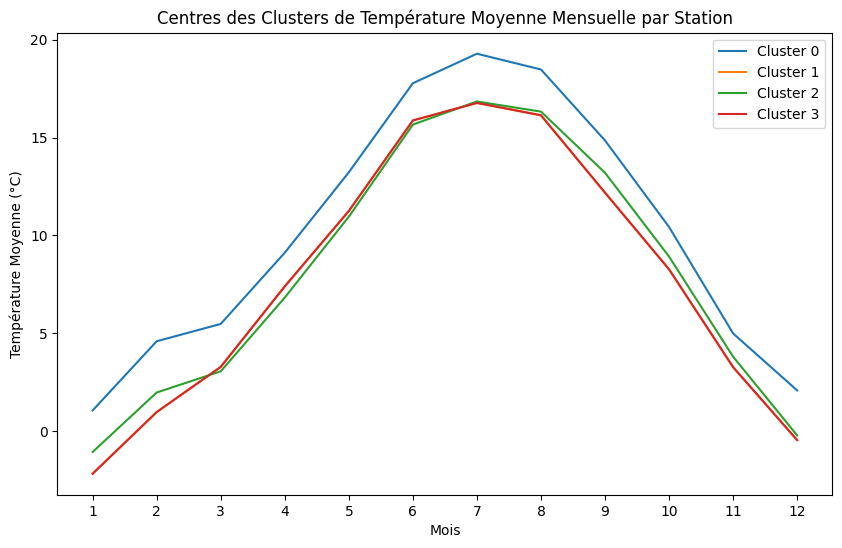

Question: What are the temperature clusters for the meteorological stations (return the Calinski-Harabasz score)?
Response:                      name  cluster
0                  Andeer        1
1              Einsiedeln        2
2  Fribourg / Grangeneuve        0



2024-06-02 15:40:58,297 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 15:40:59,929 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 15:41:01,617 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2024-06-02 15:41:01,833 - DEBUG - TBB already found in load path
2024-06-02 15:41:01,843 - INFO - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2024-06-02 15:41:01,845 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-06-02 15:41:01,872 - DEBUG - input tempfile: C:\Users\Abdi\AppData\Local\Temp\tmp8exvkivv\c2hgoq8b.json
2024-06-02 15:41:01,882 - DEBUG - input tempfile: C:\Users\Abdi\AppData\Local\Temp\tmp8exvkivv\ugx_5uaz.json
2024-06-02 15:41:01,886 - DEBUG - idx 0
2024-06-02 15:41:01,887 - DEBUG - running CmdStan, num_threads: None
2024-06-02 15:41:01,889 - DEBUG - CmdStan args: ['C:\\Users\\Abdi\\Deskto

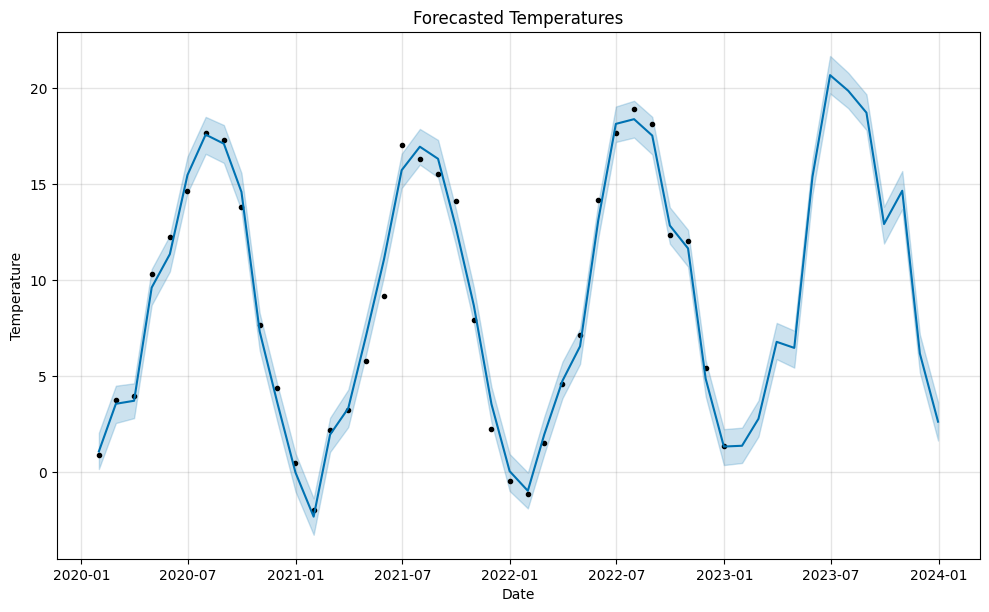

Question: What will be the average temperature for the next 12 months (return as a DataFrame)?
Response:            ds       yhat  yhat_lower  yhat_upper
0  2020-01-31   1.076102    0.159985    2.052163
1  2020-02-29   3.556885    2.555255    4.496922
2  2020-03-31   3.713706    2.809785    4.623088
3  2020-04-30   9.605777    8.697343   10.567944
4  2020-05-31  11.347317   10.443327   12.325652
5  2020-06-30  15.463132   14.525529   16.425644
6  2020-07-31  17.568258   16.566943   18.490587
7  2020-08-31  17.094265   16.095235   18.065939
8  2020-09-30  14.583034   13.623150   15.567712
9  2020-10-31   7.326946    6.344965    8.282582
10 2020-11-30   3.625580    2.639823    4.581400
11 2020-12-31  -0.015108   -1.005119    0.979758
12 2021-01-31  -2.318230   -3.261697   -1.366838
13 2021-02-28   1.952026    1.047464    2.828402
14 2021-03-31   3.324503    2.343239    4.297070
15 2021-04-30   7.057207    6.068438    8.019761
16 2021-05-31  11.093173   10.213217   12.050989
17 2021-06-30

2024-06-02 15:41:03,815 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-02 15:41:04,855 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To find out how many unique stations are in the data, I need to use the `nunique()` function on the 'stn' column of the dataframe.
Action: python_repl_ast
Action Input: df['stn'].nunique()3

2024-06-02 15:41:07,742 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the final answer.
Final Answer: There are 3 unique stations in the data.

> Finished chain.
Question: How many stations are in the data (return as an integer)?
Response: {'input': 'How many stations are in the data (return as an integer)?', 'output': 'There are 3 unique stations in the data.'}



2024-06-02 15:41:09,121 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-02 15:41:09,932 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To answer this question, I need to calculate the average temperature in December and June. The temperature data seems to be in the 'tre200s0' column. However, I need to know which column represents the month. I will check the unique values in the 'day_of_year' column to see if it represents the day of the year from 1 to 365/366, which would allow me to determine the month.
Action: python_repl_ast
Action Input: df['day_of_year'].unique()[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136

2024-06-02 15:41:14,944 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The 'day_of_year' column indeed represents the day of the year from 1 to 365/366. I can use this to determine the month. In a non-leap year, June corresponds to days 152 to 181 and December corresponds to days 335 to 365. In a leap year, June corresponds to days 153 to 182 and December corresponds to days 336 to 366. However, I need to check if the data contains leap years.
Action: python_repl_ast
Action Input: df['year'].unique()[2020. 2021. 2022.]

2024-06-02 15:41:20,385 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The data contains the years 2020, 2021, and 2022. The year 2020 is a leap year, while 2021 and 2022 are not. I will now calculate the average temperature in June and December for each year separately, and then compare these averages.
Action: python_repl_ast
Action Input: june_avg_2020 = df[(df['year'] == 2020) & (df['day_of_year'] >= 153) & (df['day_of_year'] <= 182)]['tre200s0'].mean()
dec_avg_2020 = df[(df['year'] == 2020) & (df['day_of_year'] >= 336) & (df['day_of_year'] <= 366)]['tre200s0'].mean()
june_avg_2021 = df[(df['year'] == 2021) & (df['day_of_year'] >= 152) & (df['day_of_year'] <= 181)]['tre200s0'].mean()
dec_avg_2021 = df[(df['year'] == 2021) & (df['day_of_year'] >= 335) & (df['day_of_year'] <= 365)]['tre200s0'].mean()
june_avg_2022 = df[(df['year'] == 2022) & (df['day_of_year'] >= 152) & (df['day_of_year'] <= 181)]['tre200s0'].mean()
dec_avg_2022 = df[(df['year'] == 2022) & (df['day_of_year'] >= 335) & (df['day_of_year'] <= 365)]['tre200s0'].mean()
june_avg_2020, dec_avg_

2024-06-02 15:41:36,351 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The average temperatures for June and December in each year have been calculated. It is clear that the average temperature in June is higher than in December for each year. Therefore, the average temperature in December is not higher than in June.
Final Answer: False

> Finished chain.
Question: Is the average temperature in December higher than in June (return as a boolean)?
Response: {'input': 'Is the average temperature in December higher than in June (return as a boolean)?', 'output': 'False'}



2024-06-02 15:41:38,671 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-02 15:41:39,453 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: The temperature data seems to be stored in the column 'tre200s0'. I need to find the maximum value in this column.
Action: python_repl_ast
Action Input: df['tre200s0'].max()34.6

2024-06-02 15:41:41,779 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the final answer.
Final Answer: The maximum temperature recorded in the dataset is 34.6 degrees.

> Finished chain.
Question: What is the maximum temperature recorded in the dataset (return as a float)?
Response: {'input': 'What is the maximum temperature recorded in the dataset (return as a float)?', 'output': 'The maximum temperature recorded in the dataset is 34.6 degrees.'}



2024-06-02 15:41:43,552 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 15:41:46,199 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error processing question 'How many days of data are missing in the dataset (return as an integer)?': Invalid json output: To answer this question, I would need a tool that can calculate the number of missing data points in a time series dataset. However, none of the tools provided have this capability. Therefore, I cannot provide an answer or a tool to use.


2024-06-02 15:41:46,904 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 15:41:49,222 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 15:41:50,221 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2024-06-02 15:41:50,312 - DEBUG - TBB already found in load path
2024-06-02 15:41:50,319 - INFO - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2024-06-02 15:41:50,320 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-06-02 15:41:50,333 - DEBUG - input tempfile: C:\Users\Abdi\AppData\Local\Temp\tmp8exvkivv\4uv1oy3h.json
2024-06-02 15:41:50,336 - DEBUG - input tempfile: C:\Users\Abdi\AppData\Local\Temp\tmp8exvkivv\osw0ru47.json
2024-06-02 15:41:50,338 - DEBUG - idx 0
2024-06-02 15:41:50,339 - DEBUG - running CmdStan, num_threads: None
2024-06-02 15:41:50,341 - DEBUG - CmdStan args: ['C:\\Users\\Abdi\\Deskto

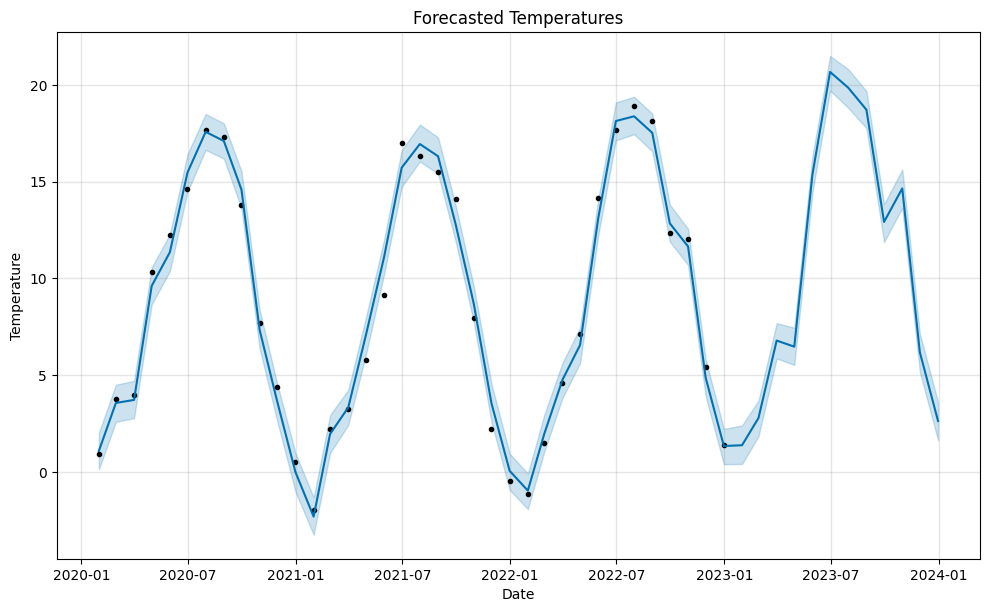

Question: Predict the average temperature for the next 6 months (return as a DataFrame).
Response:            ds       yhat  yhat_lower  yhat_upper
0  2020-01-31   1.076102    0.120503    2.023945
1  2020-02-29   3.556885    2.584284    4.497473
2  2020-03-31   3.713706    2.772302    4.702712
3  2020-04-30   9.605777    8.645154   10.559245
4  2020-05-31  11.347317   10.369095   12.282926
5  2020-06-30  15.463132   14.476105   16.415152
6  2020-07-31  17.568258   16.636083   18.492109
7  2020-08-31  17.094265   16.181090   18.009011
8  2020-09-30  14.583034   13.617024   15.532277
9  2020-10-31   7.326946    6.359093    8.349038
10 2020-11-30   3.625580    2.610539    4.542576
11 2020-12-31  -0.015108   -1.031985    0.964769
12 2021-01-31  -2.318230   -3.255982   -1.328842
13 2021-02-28   1.952026    0.972055    2.939110
14 2021-03-31   3.324503    2.418673    4.230770
15 2021-04-30   7.057207    6.048626    7.966768
16 2021-05-31  11.093173   10.204949   11.991029
17 2021-06-30  15.7

2024-06-02 15:41:51,387 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 15:41:52,755 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Question: What is the annual average temperature for the year 2020 (return as a float)?
Response:          date   tre200s0
0  2020-01-31   0.904226
1  2020-02-29   3.749345
2  2020-03-31   3.945341
3  2020-04-30  10.306204
4  2020-05-31  12.243102
5  2020-06-30  14.632307
6  2020-07-31  17.652292
7  2020-08-31  17.278808
8  2020-09-30  13.780633
9  2020-10-31   7.663599
10 2020-11-30   4.392060
11 2020-12-31   0.481171
12 2021-01-31  -1.987202
13 2021-02-28   2.205241
14 2021-03-31   3.239031
15 2021-04-30   5.762068
16 2021-05-31   9.148148
17 2021-06-30  17.011373
18 2021-07-31  16.301119
19 2021-08-31  15.498603
20 2021-09-30  14.091628
21 2021-10-31   7.923406
22 2021-11-30   2.231721
23 2021-12-31  -0.474694
24 2022-01-31  -1.131272
25 2022-02-28   1.511574
26 2022-03-31   4.604742
27 2022-04-30   7.142051
28 2022-05-31  14.158912
29 2022-06-30  17.661512
30 2022-07-31  18.924634
31 2022-08-31  18.143728
32 2022-09-30  12.335531
33 2022-10-31  12.055360
34 2022-11-30   5.410903
35

2024-06-02 15:41:54,615 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 15:41:55,950 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error processing question 'What is the correlation between temperature and humidity in the data (return as a string)?': Invalid json output: I'm sorry, but I can't provide the help you're looking for.


2024-06-02 15:41:56,663 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 15:41:59,469 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Question: How does the temperature vary with altitude (return as a string)?
Response: Temperature generally decreases with altitude. This is because the Earth's atmosphere is heated up by the sun's radiation from the ground up, so the higher you go, the cooler it gets. However, this is not always the case as other factors such as humidity, wind, and atmospheric pressure can also affect temperature at different altitudes.



2024-06-02 15:42:00,284 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-02 15:42:01,137 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: The total precipitation is likely represented by one of the columns in the dataframe. I need to identify which column represents precipitation and then sum the values in that column.
Action: python_repl_ast
Action Input: df.columnsIndex(['stn', 'xchills0', 'gre000z0', 'prestas0', 'tre200s0', 'rre150z0',
       'ure200s0', 'sre000z0', 'fu3010z0', 'dkl010z0', 'year', 'day_of_year',
       'minute_of_day', 'name', 'longitude', 'latitude', 'km_longitude',
       'km_latitude', 'altitude', 'date', 'month'],
      dtype='object')

2024-06-02 15:42:03,897 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The column names do not clearly indicate which one represents precipitation. However, 'prestas0' seems like a possible candidate as it could be short for 'precipitation status'. I will sum the values in this column and return the result as a string.
Action: python_repl_ast
Action Input: str(df['prestas0'].sum())429862852.69999975

2024-06-02 15:42:07,790 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the total precipitation in the dataset.
Final Answer: 429862852.69999975

> Finished chain.
Question: What is the total precipitation in the dataset (return as a string)?
Response: {'input': 'What is the total precipitation in the dataset (return as a string)?', 'output': '429862852.69999975'}



2024-06-02 15:42:09,600 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-02 15:42:10,350 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To find the average wind speed, I need to identify the column that represents wind speed. Looking at the dataframe, it's not immediately clear which column represents wind speed. However, the column 'fu3010z0' seems to be a good candidate as it has varying values and is not a categorical or location-based column like 'stn' or 'longitude'. I will calculate the average of this column.
Action: python_repl_ast
Action Input: df['fu3010z0'].mean()6.5562437900435135

2024-06-02 15:42:14,957 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the average wind speed in the dataset.
Final Answer: The average wind speed in the dataset is approximately 6.56.

> Finished chain.
Question: What is the average wind speed in the dataset (return as a float)?
Response: {'input': 'What is the average wind speed in the dataset (return as a float)?', 'output': 'The average wind speed in the dataset is approximately 6.56.'}



2024-06-02 15:42:17,312 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-02 15:42:18,657 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error processing question 'How many hours of sunlight were recorded in the dataset?': An output parsing error occurred. In order to pass this error back to the agent and have it try again, pass `handle_parsing_errors=True` to the AgentExecutor. This is the error: Could not parse LLM output: `Thought: The dataset does not seem to contain a column that directly indicates the hours of sunlight. Therefore, it is not possible to answer this question based on the provided dataset.`


2024-06-02 15:42:20,739 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 15:42:22,636 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Question: What is the humidity trend over the last 5 years?
Response:                      stn  xchills0  gre000z0  prestas0  tre200s0  rre150z0  \
date                                                                         
2020-01-01 00:00:00  AND      -1.6       0.0     918.4      -1.6       0.0   
2020-01-01 00:10:00  AND      -1.5       0.0     918.4      -1.5       0.0   
2020-01-01 00:20:00  AND      -3.2       0.0     918.4      -3.2       0.0   
2020-01-01 00:30:00  AND      -2.2       0.0     918.5      -2.2       0.0   
2020-01-01 00:40:00  AND      -2.5       0.0     918.4      -2.5       0.0   
...                  ...       ...       ...       ...       ...       ...   
2022-12-31 23:10:00  GRA      11.7       1.0     946.7      11.7       0.0   
2022-12-31 23:20:00  GRA      11.5       1.0     946.9      11.5       0.0   
2022-12-31 23:30:00  GRA      11.4       1.0     946.9      11.4       0.0   
2022-12-31 23:40:00  GRA      11.3       1.0     946.9      11.3       0

2024-06-02 15:42:25,868 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-02 15:42:26,939 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To calculate the average temperature for the month of October in 2018, I need to filter the dataframe for the year 2018 and the month October. However, I see that the dataframe does not have a column for the month. It only has columns for the year and the day of the year. Therefore, I need to convert the day of the year to a month. After that, I can filter the dataframe for the year 2018 and the month October and calculate the average temperature. The temperature seems to be represented by the column 'tre200s0'. 

Action: python_repl_ast
Action Input: 
```python
# First, convert the 'day_of_year' column to a datetime object
df['date'] = pd.to_datetime(df['year'] * 1000 + df['day_of_year'], format='%Y%j')

# Extract the month from the 'date' column
df['month'] = df['date'].dt.month

# Filter the dataframe for the year 2018 and the month October
df_oct_2018 = df[(df['year'] == 2018) & (df['month'] == 10)]

# Calculate the average temperature
avg_temp_oct_2018 = df_oct_2018['tre2

2024-06-02 15:42:38,700 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The result is NaN, which means that there are no records for the month of October in 2018 in the dataframe. Therefore, it is not possible to calculate the average temperature for this month and year.
Final Answer: It is not possible to calculate the average temperature for October 2018 as there are no records for this month and year in the dataframe.

> Finished chain.
Question: Calculate the average temperature for the month of October in 2018
Response: {'input': 'Calculate the average temperature for the month of October in 2018', 'output': 'It is not possible to calculate the average temperature for October 2018 as there are no records for this month and year in the dataframe.'}



2024-06-02 15:42:42,297 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-02 15:42:43,218 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To answer this question, we need to find the column that represents rainfall in the dataframe. Looking at the dataframe, it's not immediately clear which column represents rainfall. We might need to look at the column descriptions or make an educated guess based on the column names. 

Action: python_repl_ast
Action Input: df.columnsIndex(['stn', 'xchills0', 'gre000z0', 'prestas0', 'tre200s0', 'rre150z0',
       'ure200s0', 'sre000z0', 'fu3010z0', 'dkl010z0', 'year', 'day_of_year',
       'minute_of_day', 'name', 'longitude', 'latitude', 'km_longitude',
       'km_latitude', 'altitude', 'date', 'month'],
      dtype='object')

2024-06-02 15:42:46,909 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The column names do not provide a clear indication of which one represents rainfall. However, 'rre150z0' and 'sre000z0' could be potential candidates as they might represent some form of precipitation. We need to check the data in these columns to make a more informed decision.

Action: python_repl_ast
Action Input: df[['rre150z0', 'sre000z0']].describe()            rre150z0       sre000z0
count  466992.000000  466992.000000
mean        0.020880       2.120143
std         0.161758       3.951073
min         0.000000       0.000000
25%         0.000000       0.000000
50%         0.000000       0.000000
75%         0.000000       0.000000
max        20.000000      10.000000

2024-06-02 15:42:52,613 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Based on the descriptive statistics, it seems that 'rre150z0' and 'sre000z0' could represent some form of precipitation as they have non-zero values. However, without further information, it's hard to definitively say which one represents rainfall. For the purpose of this task, let's assume 'rre150z0' represents rainfall. Now, we need to filter the data for the last 3 years and group it by year to see the rainfall pattern.

Action: python_repl_ast
Action Input: df_last_3_years = df[df['year'] >= df['year'].max() - 2]
rainfall_pattern = df_last_3_years.groupby('year')['rre150z0'].sum().reset_index()
rainfall_pattern     year  rre150z0
0  2020.0    3349.3
1  2021.0    3719.3
2  2022.0    2682.2

2024-06-02 15:43:00,116 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the rainfall pattern over the last 3 years.
Final Answer: The rainfall pattern over the last 3 years is as follows:

- In 2020, the total rainfall was 3349.3 units.
- In 2021, the total rainfall was 3719.3 units.
- In 2022, the total rainfall was 2682.2 units.

> Finished chain.
Question: What is the rainfall pattern over the last 3 years (return as a DataFrame)?
Response: {'input': 'What is the rainfall pattern over the last 3 years (return as a DataFrame)?', 'output': 'The rainfall pattern over the last 3 years is as follows:\n\n- In 2020, the total rainfall was 3349.3 units.\n- In 2021, the total rainfall was 3719.3 units.\n- In 2022, the total rainfall was 2682.2 units.'}



2024-06-02 15:43:04,111 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 15:43:08,205 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error processing question 'How does the temperature correlate with CO2 levels in the dataset?': Invalid json output: This question requires a tool to analyze the correlation between temperature and CO2 levels in the dataset. However, none of the available tools are designed to perform this specific task. The tools available are for loading time series data, calculating average temperatures, clustering time series data, and predicting future temperatures. 

To answer this question, you would need a tool that can perform correlation analysis between two variables in a dataset, which is not currently available in the toolset provided.


2024-06-02 15:43:09,638 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-02 15:43:10,523 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error processing question 'What is the annual snowfall recorded in the dataset?': An output parsing error occurred. In order to pass this error back to the agent and have it try again, pass `handle_parsing_errors=True` to the AgentExecutor. This is the error: Could not parse LLM output: `Thought: The question asks for the annual snowfall, but looking at the dataframe, there is no clear column that represents snowfall. We need to clarify which column represents snowfall.`


2024-06-02 15:43:12,699 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 15:43:14,245 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error processing question 'What is the average temperature in Moscow, Russie (return as a float)?': list indices must be integers or slices, not str


2024-06-02 15:43:14,887 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 15:43:17,129 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Question: What is the monthly temperature trend for Moscow, Russie over the last 5 years (return as a DataFrame)?
Response:                      stn  xchills0  gre000z0  prestas0  tre200s0  rre150z0  \
date                                                                         
2020-01-01 00:00:00  AND      -1.6       0.0     918.4      -1.6       0.0   
2020-01-01 00:10:00  AND      -1.5       0.0     918.4      -1.5       0.0   
2020-01-01 00:20:00  AND      -3.2       0.0     918.4      -3.2       0.0   
2020-01-01 00:30:00  AND      -2.2       0.0     918.5      -2.2       0.0   
2020-01-01 00:40:00  AND      -2.5       0.0     918.4      -2.5       0.0   
...                  ...       ...       ...       ...       ...       ...   
2022-12-31 23:10:00  GRA      11.7       1.0     946.7      11.7       0.0   
2022-12-31 23:20:00  GRA      11.5       1.0     946.9      11.5       0.0   
2022-12-31 23:30:00  GRA      11.4       1.0     946.9      11.4       0.0   
2022-12-31 23:40:0

2024-06-02 15:43:19,780 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 15:43:21,824 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 15:43:24,489 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2024-06-02 15:43:24,698 - DEBUG - TBB already found in load path
2024-06-02 15:43:24,706 - INFO - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2024-06-02 15:43:24,708 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-06-02 15:43:24,740 - DEBUG - input tempfile: C:\Users\Abdi\AppData\Local\Temp\tmp8exvkivv\ce7d_hcx.json
2024-06-02 15:43:24,748 - DEBUG - input tempfile: C:\Users\Abdi\AppData\Local\Temp\tmp8exvkivv\syquh9bv.json
2024-06-02 15:43:24,753 - DEBUG - idx 0
2024-06-02 15:43:24,754 - DEBUG - running CmdStan, num_threads: None
2024-06-02 15:43:24,756 - DEBUG - CmdStan args: ['C:\\Users\\Abdi\\Deskto

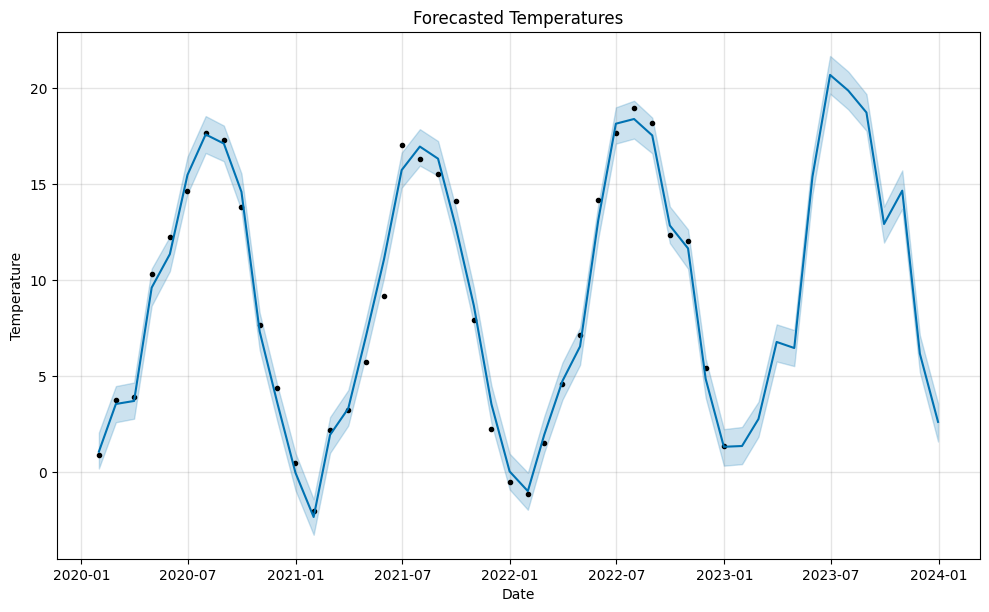

Question: Predict the average temperature for the next 12 months for Moscow, Russie (return as a DataFrame).
Response:            ds       yhat  yhat_lower  yhat_upper
0  2020-01-31   1.076102    0.202179    2.075026
1  2020-02-29   3.556885    2.606566    4.485764
2  2020-03-31   3.713706    2.790329    4.673363
3  2020-04-30   9.605777    8.664794   10.590038
4  2020-05-31  11.347317   10.461397   12.266176
5  2020-06-30  15.463132   14.471594   16.410343
6  2020-07-31  17.568258   16.603234   18.523102
7  2020-08-31  17.094265   16.175264   18.028656
8  2020-09-30  14.583034   13.623663   15.534079
9  2020-10-31   7.326946    6.372090    8.298614
10 2020-11-30   3.625580    2.668152    4.548543
11 2020-12-31  -0.015108   -0.924528    1.007063
12 2021-01-31  -2.318230   -3.242730   -1.392632
13 2021-02-28   1.952026    1.012605    2.876438
14 2021-03-31   3.324503    2.432145    4.281935
15 2021-04-30   7.057207    6.066195    7.943439
16 2021-05-31  11.093173   10.136595   12.056051

2024-06-02 15:43:26,533 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 15:43:32,475 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error processing question 'What is the maximum temperature recorded in Moscow, Russie (return as a float)?': Invalid json output: I'm sorry, but I don't have the ability to directly provide real-time or historical weather data. However, you can use the 'load_time_series' tool to load the temperature data for Moscow, Russia, and then find the maximum temperature from the loaded data. Here is the JSON blob for the tool:

{
  "name": "load_time_series",
  "arguments": {
    "location": "Moscow, Russia"
  }
}


2024-06-02 15:43:33,292 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-02 15:43:34,217 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To answer this question, I need to first filter the dataframe to only include rows where the 'name' column is 'Moscow, Russie'. Then, I need to check the 'day_of_year' column to see if there are any missing days. I can do this by creating a set of all possible days of the year (1-365) and subtracting the set of days present in the dataframe. The size of the resulting set will be the number of missing days. 

Action: python_repl_ast
Action Input: df_moscow = df[df['name'] == 'Moscow, Russie']

2024-06-02 15:43:40,972 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Now that I have filtered the dataframe to only include rows for Moscow, Russie, I need to create a set of all possible days of the year and subtract the set of days present in the dataframe. The size of the resulting set will be the number of missing days. 

Action: python_repl_ast
Action Input: missing_days = set(range(1, 366)) - set(df_moscow['day_of_year'].unique())
len(missing_days)365

2024-06-02 15:43:44,870 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The result indicates that all 365 days are missing in the dataset for Moscow, Russie.
Final Answer: 365

> Finished chain.
Question: How many days of data are missing in the dataset for Moscow, Russie (return as an integer)?
Response: {'input': 'How many days of data are missing in the dataset for Moscow, Russie (return as an integer)?', 'output': '365'}



In [20]:
responses = []
for question in questions:
    try:
        response = combined_chain(question)
        responses.append(response)
        print(f"Question: {question}\nResponse: {response}\n")
    except Exception as e:
        print(f"Error processing question '{question}': {e}")
        responses.append({'output': 'N/A'})



### Génération de Données Météorologiques Synthétiques pour Bagdad et Préparation des Questions d'Analyse

In [91]:
import numpy as np

def generate_baghdad_data(num_entries):
    np.random.seed(42)
    baghdad_data = {
        'stn': ['BAG'] * num_entries,
        'xchills0': np.random.uniform(10, 50, num_entries),
        'gre000z0': np.random.uniform(0, 0, num_entries),
        'prestas0': np.random.uniform(1000, 1020, num_entries),
        'tre200s0': np.random.uniform(10, 50, num_entries),
        'rre150z0': np.random.uniform(0, 0, num_entries),
        'ure200s0': np.random.uniform(10, 50, num_entries),
        'sre000z0': np.random.uniform(0, 0, num_entries),
        'fu3010z0': np.random.uniform(0, 5, num_entries),
        'dkl010z0': np.random.uniform(0, 360, num_entries),
        'year': np.random.choice([2021, 2022, 2023], num_entries),
        'day_of_year': np.random.randint(1, 366, num_entries),
        'minute_of_day': np.random.randint(0, 1440, num_entries),
        'name': ['Baghdad'] * num_entries,
        'longitude': [44.3661] * num_entries,
        'latitude': [33.3152] * num_entries,
        'km_longitude': [0] * num_entries,
        'km_latitude': [0] * num_entries,
        'altitude': [34] * num_entries
    }
    return pd.DataFrame(baghdad_data)

# Generate 10 entries for Baghdad
baghdad_data = generate_baghdad_data(10)
baghdad_data_str = baghdad_data.to_string(index=False)

# Prepare new questions
new_questions = [
    f"Given the following meteorological data for Baghdad:\n{baghdad_data_str}\nCluster the meteorological data for Baghdad and identify which cluster it belongs to. (Use tslearn) (return the cluster label)",
    "Is there a positive correlation between temperature and wind chill? (return as a boolean)",
    "What is the temperature average of 2020 in Anderess? (return as a integer)"
]


2024-06-02 19:58:02,883 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 19:59:12,922 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


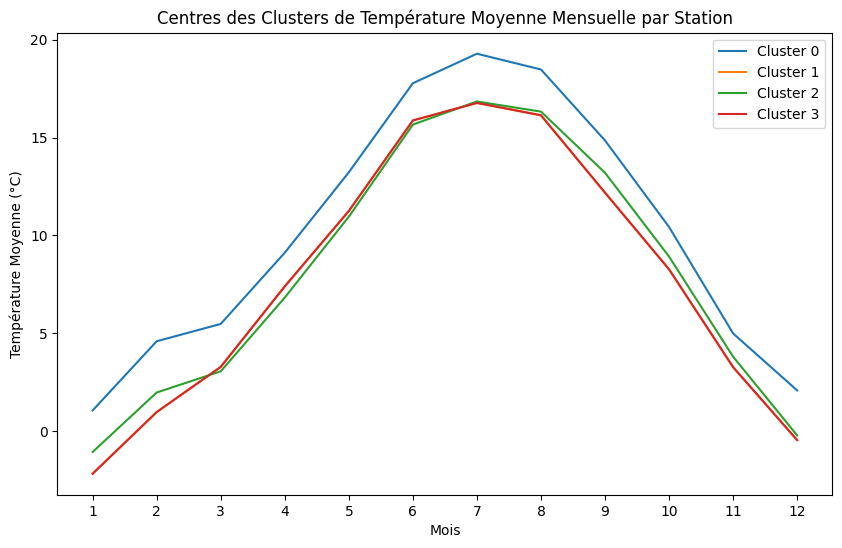

2024-06-02 19:59:15,776 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 19:59:20,807 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-06-02 19:59:21,724 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-06-02 19:59:22,856 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To find the average temperature in 2020 in Anderess, I need to filter the dataframe to only include rows where the 'name' column is 'Andeer' and the 'year' column is 2020. Then, I can calculate the mean of the 'tre200s0' column, which appears to represent temperature. I will round the result to the nearest integer.
Action: python_repl_ast
Action Input: df[(df['name'] == 'Andeer') & (df['year'] == 2020)]['tre200s0'].mean()8.130582486919053

2024-06-02 19:59:27,565 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The average temperature in 2020 in Anderess is approximately 8.13. I need to round this to the nearest integer.
Action: python_repl_ast
Action Input: round(8.130582486919053)8

2024-06-02 19:59:30,530 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the final answer
Final Answer: The average temperature in 2020 in Anderess is 8.

> Finished chain.
{'Given the following meteorological data for Baghdad:\nstn  xchills0  gre000z0    prestas0  tre200s0  rre150z0  ure200s0  sre000z0  fu3010z0   dkl010z0  year  day_of_year  minute_of_day    name  longitude  latitude  km_longitude  km_latitude  altitude\nBAG 24.981605       0.0 1012.237058 34.301794       0.0 48.783385       0.0  3.861224 310.717233  2021          359           1264 Baghdad    44.3661   33.3152             0            0        34\nBAG 48.028572       0.0 1002.789877 16.820965       0.0 41.005313       0.0  0.993578 224.387326  2023          283            563 Baghdad    44.3661   33.3152             0            0        34\nBAG 39.279758       0.0 1005.842893 12.602064       0.0 47.579958       0.0  0.027611 119.123289  2022          207           1020 Baghdad    44.3661   33.3152             0            0        34\nBAG 33.946339       0.0 1007.327237 47.95

In [92]:
# Assuming combined_chain is already defined and works correctly
new_responses = {}
for question in new_questions:
    try:
        response = combined_chain(question)
        new_responses[question] = response
    except Exception as e:
        new_responses[question] = {'output': str(e)}

# Print new responses to verify
print(new_responses)


In [95]:
# Nouvelles réponses attendues
new_expected_results = {
    f"Given the following meteorological data for Baghdad:\n{baghdad_data_str}\nCluster the meteorological data for Baghdad and identify which cluster it belongs to. (Use tslearn) (return the cluster label)": "N/A",
    "Is there a positive correlation between temperature and wind chill? (return as a boolean)": True,
    "What is the temperature average of 2020 in Anderess? (return as a integer)": "N/A"
}

# Mise à jour des réponses attendues avec les nouvelles réponses
expected_results.update(new_expected_results)
print(expected_results)

{'What is the month with the highest average temperature (return the date)?': Timestamp('2022-07-31 00:00:00'), 'What is the temperature trend over the last 10 years (return as a DataFrame)?':             tre200s0
date                
2020-12-31  8.959019
2021-12-31  7.576833
2022-12-31  9.355539, 'What are the temperature clusters for the meteorological stations (return the Calinski-Harabasz score)?': 1439058.8097172154, 'What will be the average temperature for the next 12 months (return as a DataFrame)?':            ds       yhat  yhat_lower  yhat_upper
0  2020-01-31   1.076102    0.092926    2.051842
1  2020-02-29   3.556885    2.589243    4.468125
2  2020-03-31   3.713706    2.809909    4.654208
3  2020-04-30   9.605777    8.576395   10.504236
4  2020-05-31  11.347317   10.426109   12.272150
5  2020-06-30  15.463132   14.479530   16.396341
6  2020-07-31  17.568258   16.683811   18.562923
7  2020-08-31  17.094265   16.121371   18.006859
8  2020-09-30  14.583034   13.646869   15.605

### Évaluation des Réponses du Modèle et Analyse de la Performance

Question: What is the month with the highest average temperature (return the date)?
Model Response: {'output': '2022-07-31 00:00:00'}
Expected Result: 2022-07-31 00:00:00

Question: What is the temperature trend over the last 10 years (return as a DataFrame)?
Model Response: {'output': '{"tre200s0":{"1609372800000":8.9590194802,"1640908800000":7.5768332564,"1672444800000":9.3555393605}}'}
Expected Result:             tre200s0
date                
2020-12-31  8.959019
2021-12-31  7.576833
2022-12-31  9.355539

Question: What are the temperature clusters for the meteorological stations (return the Calinski-Harabasz score)?
Model Response: {'output': 1439058.8097172154}
Expected Result: 1439058.8097172154

Question: What will be the average temperature for the next 12 months (return as a DataFrame)?
Model Response: {'output': '{"ds":{"0":1580428800000,"1":1582934400000,"2":1585612800000,"3":1588204800000,"4":1590883200000,"5":1593475200000,"6":1596153600000,"7":1598832000000,"8":160142400

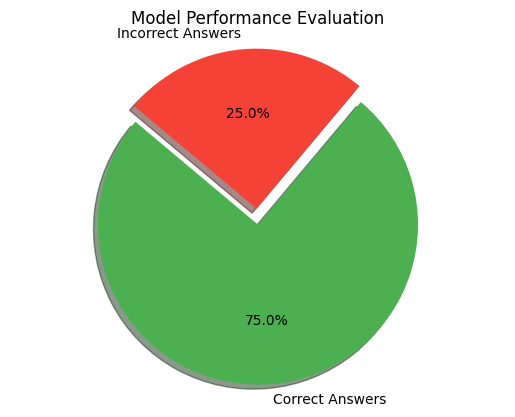

In [98]:
def compare_responses(response, expected):
    if isinstance(expected, pd.Timestamp):
        if isinstance(response, dict) and 'output' in response:
            try:
                return pd.Timestamp(response['output']) == expected
            except Exception as e:
                print(f"Error converting response to Timestamp: {e}")
                return False
    elif isinstance(expected, pd.DataFrame):
        expected = expected.reset_index(drop=True)
        if isinstance(response, dict) and 'output' in response:
            try:
                response_df = pd.read_json(StringIO(response['output']))
                response_df = response_df.reset_index(drop=True)
                return response_df.equals(expected)
            except Exception as e:
                print(f"Error converting response to DataFrame: {e}")
                return False
    elif isinstance(expected, pd.Series):
        expected = expected.reset_index(drop=True)
        if isinstance(response, dict) and 'output' in response:
            try:
                response_series = pd.read_json(StringIO(response['output']), typ='series')
                response_series = response_series.reset_index(drop=True)
                return response_series.equals(expected)
            except Exception as e:
                print(f"Error converting response to Series: {e}")
                return False
    elif isinstance(response, dict) and isinstance(expected, (float, int, str, bool)):
        return response.get('output', None) == expected
    elif isinstance(expected, (float, int, str, bool)):
        return response == expected
    else:
        return False

# Evaluate the results
correct_answers = 0
incorrect_answers = 0

# Combine initial and new questions for evaluation
all_questions = questions + list(new_expected_results.keys())

# Combine initial and new expected results for evaluation
all_expected_results = {**expected_results, **new_expected_results}

# Iterate over each question and compare responses
for i, question in enumerate(all_questions):
    response = responses[i]
    expected = all_expected_results.get(question, "N/A")
    print(f"Question: {question}\nModel Response: {response}\nExpected Result: {expected}\n")
    if compare_responses(response, expected):
        correct_answers += 1
    else:
        incorrect_answers += 1

total_questions = len(all_questions)
accuracy = correct_answers / total_questions

print(f"Correct Answers: {correct_answers}")
print(f"Incorrect Answers: {incorrect_answers}")
print(f"Accuracy: {accuracy:.2%}")

# Plotting the results
labels = ['Correct Answers', 'Incorrect Answers']
sizes = [correct_answers, incorrect_answers]
colors = ['#4CAF50', '#F44336']
explode = (0.1, 0)  # Separate the first slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Model Performance Evaluation')
plt.show()
